In [26]:
import os
import pandas as pd 
import matplotlib.pyplot as plt
#plt.rcParams['font.family'] = 'AppleGothic' # 폰트 변경
#plt.rcParams['axes.unicode_minus'] = False # 축 값 마이너스 깨짐 해결
import numpy as np
from torch.nn import Transformer
from torch import nn
import torch
import math
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import mean_absolute_percentage_error ,mean_squared_error

In [2]:
path = '~/workplace/datas/energy/'
#path = '~/Desktop/workplace/datas/energy/'

In [3]:
train_df = pd.read_csv(path + 'encoded_train_df.csv', index_col=0)
test_df = pd.read_csv(path + 'encoded_test_df.csv', index_col=0)

In [4]:
train_df

,Year,Month,Day,Hour,기온(°C),풍속(m/s),습도(%),현지기압(hPa),지면온도(°C),강수량(mm),적설(cm),일조(hr),일사(MJ/m2),smp(원/kWh),발전량,휴일,5분전_현재수요(MW),1시간전_현재수요(MW),하루전_현재수요(MW),현재수요(MW)
일시,,,,,,,,,,,,,,,,,,,,
2018-01-02 01:05:00,2018,1,2,1,-2.955526,1.016140,67.514912,1015.174211,-3.007807,0.000000,0.022105,0.0,0.0,91.991667,5246.400000,0,58703.40,60556.60,58194.60,58466.40
2018-01-02 01:10:00,2018,1,2,1,-2.994211,1.009123,67.735088,1015.189474,-3.031404,0.000000,0.022105,0.0,0.0,91.723333,5246.400000,0,58466.40,60158.70,57830.60,58508.60
2018-01-02 01:15:00,2018,1,2,1,-3.032895,1.002105,67.955263,1015.204737,-3.055000,0.000000,0.022105,0.0,0.0,91.455000,10428.000000,0,58508.60,59842.30,57745.30,58209.90
2018-01-02 01:20:00,2018,1,2,1,-3.071579,0.995088,68.175439,1015.220000,-3.078596,0.000000,0.022105,0.0,0.0,91.186667,5731.200000,0,58209.90,59771.70,57329.60,58080.50
2018-01-02 01:25:00,2018,1,2,1,-3.110263,0.988070,68.395614,1015.235263,-3.102193,0.000000,0.022105,0.0,0.0,90.918333,6254.400000,0,58080.50,59393.60,57219.70,57942.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-12 23:35:00,2023,3,12,23,1.765000,5.063684,46.180702,1010.276667,1.134386,0.025482,0.011491,0.0,0.0,220.551667,39745.380277,0,60357.25,60754.29,58773.93,60235.18
2023-03-12 23:40:00,2023,3,12,23,1.720000,5.050526,46.045614,1010.288070,1.095088,0.029123,0.011930,0.0,0.0,223.523333,39745.380277,0,60235.18,60707.96,58326.83,60106.61
2023-03-12 23:45:00,2023,3,12,23,1.675000,5.037368,45.910526,1010.299474,1.055789,0.032763,0.012368,0.0,0.0,226.495000,39745.380277,0,60106.61,60673.42,58038.45,59725.49


In [5]:
X = train_df.iloc[:, :-1]
X.drop(['5분전_현재수요(MW)', '1시간전_현재수요(MW)'], axis=1, inplace=True)
y = train_df.iloc[:, -1]

In [6]:
X_test = test_df.iloc[:, :-1]
X_test.drop(['5분전_현재수요(MW)', '1시간전_현재수요(MW)'], axis=1, inplace=True)
y_test = test_df.iloc[:, -1]

In [7]:
X.shape, y.shape, X_test.shape, y_test.shape

((546035, 17), (546035,), (2016, 17), (2016,))

# mRMR

In [8]:
#mRMR
from mrmr import mrmr_classif, mrmr_regression
selected_features = mrmr_regression(X=X, y=y, K=20, return_scores=True)

100%|███████████████████████████████████████████| 17/17 [00:19<00:00,  1.12s/it]


In [9]:
selected_features

(['하루전_현재수요(MW)',
  'Hour',
  '휴일',
  '적설(cm)',
  'smp(원/kWh)',
  '풍속(m/s)',
  '습도(%)',
  '일조(hr)',
  '발전량',
  '현지기압(hPa)',
  'Year',
  'Month',
  '일사(MJ/m2)',
  '기온(°C)',
  'Day',
  '지면온도(°C)',
  '강수량(mm)'],
 Year              2860.884640
 Month             1682.232189
 Day                151.384261
 Hour             66369.451132
 기온(°C)            4006.375704
 풍속(m/s)          22691.984785
 습도(%)            25356.101253
 현지기압(hPa)         3340.531774
 지면온도(°C)           871.292241
 강수량(mm)             44.465668
 적설(cm)           42858.655050
 일조(hr)           12527.003168
 일사(MJ/m2)         6372.065627
 smp(원/kWh)       43467.539457
 발전량               8353.840599
 휴일               27191.463755
 하루전_현재수요(MW)    783073.146561
 dtype: float64,
                   Year     Month       Day      Hour    기온(°C)   풍속(m/s)  \
 Year          0.001000  0.001000  0.001000  0.001000  0.001000  0.020105   
 Month         0.099795  0.001000  0.001000  0.001000  0.001000  0.139199   
 Day           0

In [46]:
mrmr = []

for i , j in enumerate(selected_features[0]):
    mrmr.append([(i+1),j])

In [47]:
mrmr = pd.DataFrame(mrmr, columns=['rank', 'features'])

In [48]:
mrmr

,rank,features
0,1,하루전_현재수요(MW)
1,2,Hour
2,3,휴일
3,4,적설(cm)
4,5,smp(원/kWh)
5,6,풍속(m/s)
6,7,습도(%)
7,8,일조(hr)
8,9,발전량
9,10,현지기압(hPa)


# SAHP

findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

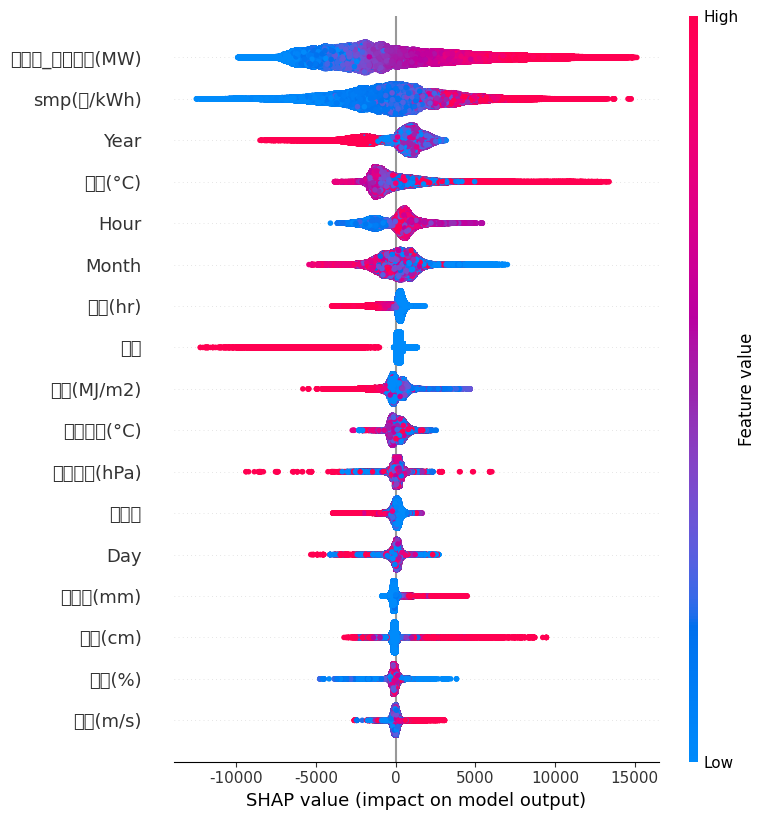

In [27]:
import shap
import lightgbm as lgb
import xgboost as xgb

model = xgb.XGBRegressor()
model.fit(X, y)


explainer = shap.Explainer(model)



shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

In [39]:
import numpy as np

# Calculate mean absolute SHAP values
mean_shap_values = np.mean(np.abs(shap_values), axis=0)

# Print feature importance
shap = []
for feature_name, mean_value in zip(X.keys(), mean_shap_values):
    print(f"{feature_name}: {mean_value}")
    shap.append([mean_value,feature_name])


Year: 1343.194091796875
Month: 847.5585327148438
Day: 229.39772033691406
Hour: 967.72900390625
기온(°C): 1182.8192138671875
풍속(m/s): 138.6793212890625
습도(%): 164.1550750732422
현지기압(hPa): 236.7960662841797
지면온도(°C): 339.4438781738281
강수량(mm): 209.92198181152344
적설(cm): 198.66371154785156
일조(hr): 497.23388671875
일사(MJ/m2): 451.15673828125
smp(원/kWh): 2434.31982421875
발전량: 229.66763305664062
휴일: 452.33160400390625
하루전_현재수요(MW): 3468.33984375


In [40]:
shap = pd.DataFrame(shap, columns=['value', 'features'])

In [41]:
shap.sort_values('value', ascending=False, inplace=True)

In [42]:
shap['rank'] = [i for i in range(1, len(shap) + 1)]

In [43]:
shap.rename(columns={'rank':'shap_rank'}, inplace=True)

In [49]:
mrmr.set_index(['features'], inplace=True)
shap.set_index(['features'], inplace=True)

In [34]:
shap

,value,features,shap_rank
16,3468.339844,하루전_현재수요(MW),1
13,2434.319824,smp(원/kWh),2
0,1343.194092,Year,3
4,1182.819214,기온(°C),4
3,967.729004,Hour,5
1,847.558533,Month,6
11,497.233887,일조(hr),7
15,452.331604,휴일,8
12,451.156738,일사(MJ/m2),9
8,339.443878,지면온도(°C),10


In [50]:
merge_df = pd.merge(mrmr, shap, left_index=True, right_index=True)
merge_df.drop('value', axis=1, inplace=True)

In [51]:
merge_df['sum'] = (merge_df['rank'] ** 2) + (merge_df['shap_rank'] **2)

In [52]:
merge_df.sort_values('sum', ascending=True, inplace=True)

In [53]:
merge_df

,rank,shap_rank,sum
features,,,
하루전_현재수요(MW),1,1,2
Hour,2,5,29
smp(원/kWh),5,2,29
휴일,3,8,73
일조(hr),8,7,113
Year,11,3,130
Month,12,6,180
기온(°C),14,4,212
현지기압(hPa),10,11,221


# 인덱스 순위

In [54]:
merge_df.index

Index(['하루전_현재수요(MW)', 'Hour', 'smp(원/kWh)', '휴일', '일조(hr)', 'Year', 'Month',
       '기온(°C)', '현지기압(hPa)', '발전량', '적설(cm)', '일사(MJ/m2)', '습도(%)', '풍속(m/s)',
       '지면온도(°C)', 'Day', '강수량(mm)'],
      dtype='object', name='features')

In [57]:
X = X[merge_df.index[:-7]]
X

,하루전_현재수요(MW),Hour,smp(원/kWh),휴일,일조(hr),Year,Month,기온(°C),현지기압(hPa),발전량
일시,,,,,,,,,,
2018-01-02 01:05:00,58194.60,1,91.991667,0,0.0,2018,1,-2.955526,1015.174211,5246.400000
2018-01-02 01:10:00,57830.60,1,91.723333,0,0.0,2018,1,-2.994211,1015.189474,5246.400000
2018-01-02 01:15:00,57745.30,1,91.455000,0,0.0,2018,1,-3.032895,1015.204737,10428.000000
2018-01-02 01:20:00,57329.60,1,91.186667,0,0.0,2018,1,-3.071579,1015.220000,5731.200000
2018-01-02 01:25:00,57219.70,1,90.918333,0,0.0,2018,1,-3.110263,1015.235263,6254.400000
...,...,...,...,...,...,...,...,...,...,...
2023-03-12 23:35:00,58773.93,23,220.551667,0,0.0,2023,3,1.765000,1010.276667,39745.380277
2023-03-12 23:40:00,58326.83,23,223.523333,0,0.0,2023,3,1.720000,1010.288070,39745.380277
2023-03-12 23:45:00,58038.45,23,226.495000,0,0.0,2023,3,1.675000,1010.299474,39745.380277


In [58]:
X_test = X_test.reindex(columns=merge_df.index)

X_test = X_test.iloc[:, :-7]

In [59]:
X.shape, X_test.shape, y.shape, y_test.shape

((546035, 10), (2016, 10), (546035,), (2016,))

In [60]:
from flaml import AutoML
from flaml.ml import sklearn_metric_loss_score

model = AutoML()


model.fit(X, y, task='regression',
          time_budget=10800,
          metric='mse',
          log_file_name='electric.log')

print(model._best_estimator)
print(model.best_result)
print(model.best_config)

[flaml.automl.logger: 07-20 15:47:35] {1693} INFO - task = regression
[flaml.automl.logger: 07-20 15:47:35] {1700} INFO - Data split method: uniform
[flaml.automl.logger: 07-20 15:47:35] {1703} INFO - Evaluation method: holdout
[flaml.automl.logger: 07-20 15:47:35] {1801} INFO - Minimizing error metric: mse
[flaml.automl.logger: 07-20 15:47:35] {1911} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.logger: 07-20 15:47:35] {2221} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-20 15:47:35] {2347} INFO - Estimated sufficient time budget=43165s. Estimated necessary time budget=369s.
[flaml.automl.logger: 07-20 15:47:35] {2394} INFO -  at 0.7s,	estimator lgbm's best error=54400985.9273,	best estimator lgbm's best error=54400985.9273
[flaml.automl.logger: 07-20 15:47:35] {2221} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-20 15:47:35] {2394} INFO -  at 0.7s,	estimator lgbm's 

[flaml.automl.logger: 07-20 15:47:37] {2221} INFO - iteration 32, current learner lgbm
[flaml.automl.logger: 07-20 15:47:38] {2394} INFO -  at 3.3s,	estimator lgbm's best error=10239039.2161,	best estimator lgbm's best error=10239039.2161
[flaml.automl.logger: 07-20 15:47:38] {2221} INFO - iteration 33, current learner extra_tree
[flaml.automl.logger: 07-20 15:47:38] {2394} INFO -  at 3.4s,	estimator extra_tree's best error=18688495.5507,	best estimator lgbm's best error=10239039.2161
[flaml.automl.logger: 07-20 15:47:38] {2221} INFO - iteration 34, current learner lgbm
[flaml.automl.logger: 07-20 15:47:38] {2394} INFO -  at 3.7s,	estimator lgbm's best error=7528171.7967,	best estimator lgbm's best error=7528171.7967
[flaml.automl.logger: 07-20 15:47:38] {2221} INFO - iteration 35, current learner rf
[flaml.automl.logger: 07-20 15:47:38] {2394} INFO -  at 3.8s,	estimator rf's best error=25555511.0666,	best estimator lgbm's best error=7528171.7967
[flaml.automl.logger: 07-20 15:47:38] {

[flaml.automl.logger: 07-20 15:48:18] {2394} INFO -  at 43.0s,	estimator lgbm's best error=1566486.7589,	best estimator lgbm's best error=1566486.7589
[flaml.automl.logger: 07-20 15:48:18] {2221} INFO - iteration 67, current learner xgb_limitdepth
[flaml.automl.logger: 07-20 15:48:18] {2394} INFO -  at 43.1s,	estimator xgb_limitdepth's best error=23089718.6102,	best estimator lgbm's best error=1566486.7589
[flaml.automl.logger: 07-20 15:48:18] {2221} INFO - iteration 68, current learner xgb_limitdepth
[flaml.automl.logger: 07-20 15:48:18] {2394} INFO -  at 43.1s,	estimator xgb_limitdepth's best error=23089718.6102,	best estimator lgbm's best error=1566486.7589
[flaml.automl.logger: 07-20 15:48:18] {2221} INFO - iteration 69, current learner xgb_limitdepth
[flaml.automl.logger: 07-20 15:48:18] {2394} INFO -  at 43.1s,	estimator xgb_limitdepth's best error=18180932.3597,	best estimator lgbm's best error=1566486.7589
[flaml.automl.logger: 07-20 15:48:18] {2221} INFO - iteration 70, curren

[flaml.automl.logger: 07-20 15:48:56] {2394} INFO -  at 81.2s,	estimator xgboost's best error=13107043.1257,	best estimator lgbm's best error=534444.6375
[flaml.automl.logger: 07-20 15:48:56] {2221} INFO - iteration 100, current learner xgboost
[flaml.automl.logger: 07-20 15:48:56] {2394} INFO -  at 81.5s,	estimator xgboost's best error=10187235.2123,	best estimator lgbm's best error=534444.6375
[flaml.automl.logger: 07-20 15:48:56] {2221} INFO - iteration 101, current learner xgboost
[flaml.automl.logger: 07-20 15:48:56] {2394} INFO -  at 81.5s,	estimator xgboost's best error=10187235.2123,	best estimator lgbm's best error=534444.6375
[flaml.automl.logger: 07-20 15:48:56] {2221} INFO - iteration 102, current learner xgb_limitdepth
[flaml.automl.logger: 07-20 15:48:57] {2394} INFO -  at 82.3s,	estimator xgb_limitdepth's best error=7340541.8534,	best estimator lgbm's best error=534444.6375
[flaml.automl.logger: 07-20 15:48:57] {2221} INFO - iteration 103, current learner xgboost
[flaml.

[flaml.automl.logger: 07-20 16:05:22] {2221} INFO - iteration 133, current learner xgb_limitdepth
[flaml.automl.logger: 07-20 16:05:27] {2394} INFO -  at 1072.1s,	estimator xgb_limitdepth's best error=5312220.2004,	best estimator lgbm's best error=335981.4605
[flaml.automl.logger: 07-20 16:05:27] {2221} INFO - iteration 134, current learner rf
[flaml.automl.logger: 07-20 16:05:27] {2394} INFO -  at 1072.9s,	estimator rf's best error=6355460.3721,	best estimator lgbm's best error=335981.4605
[flaml.automl.logger: 07-20 16:05:27] {2221} INFO - iteration 135, current learner catboost
[flaml.automl.logger: 07-20 16:05:48] {2394} INFO -  at 1093.8s,	estimator catboost's best error=3685291.5417,	best estimator lgbm's best error=335981.4605
[flaml.automl.logger: 07-20 16:05:48] {2221} INFO - iteration 136, current learner extra_tree
[flaml.automl.logger: 07-20 16:05:49] {2394} INFO -  at 1094.8s,	estimator extra_tree's best error=11359411.7849,	best estimator lgbm's best error=335981.4605
[fl

[flaml.automl.logger: 07-20 16:57:49] {2394} INFO -  at 4214.9s,	estimator rf's best error=6250634.4160,	best estimator lgbm's best error=210319.4880
[flaml.automl.logger: 07-20 16:57:49] {2221} INFO - iteration 167, current learner catboost
[flaml.automl.logger: 07-20 16:58:15] {2394} INFO -  at 4240.4s,	estimator catboost's best error=2340360.7028,	best estimator lgbm's best error=210319.4880
[flaml.automl.logger: 07-20 16:58:15] {2221} INFO - iteration 168, current learner catboost
[flaml.automl.logger: 07-20 16:58:28] {2394} INFO -  at 4253.3s,	estimator catboost's best error=2340360.7028,	best estimator lgbm's best error=210319.4880
[flaml.automl.logger: 07-20 16:58:28] {2221} INFO - iteration 169, current learner xgboost
[flaml.automl.logger: 07-20 16:58:49] {2394} INFO -  at 4274.5s,	estimator xgboost's best error=8656457.7452,	best estimator lgbm's best error=210319.4880
[flaml.automl.logger: 07-20 16:58:49] {2221} INFO - iteration 170, current learner lgbm
[flaml.automl.logger

[flaml.automl.logger: 07-20 17:58:13] {2394} INFO -  at 7838.3s,	estimator catboost's best error=2340360.7028,	best estimator lgbm's best error=170899.4550
[flaml.automl.logger: 07-20 17:58:13] {2221} INFO - iteration 201, current learner extra_tree
[flaml.automl.logger: 07-20 17:58:14] {2394} INFO -  at 7839.3s,	estimator extra_tree's best error=11265584.3593,	best estimator lgbm's best error=170899.4550
[flaml.automl.logger: 07-20 17:58:14] {2221} INFO - iteration 202, current learner lgbm
[flaml.automl.logger: 07-20 18:17:29] {2394} INFO -  at 8994.1s,	estimator lgbm's best error=165846.4671,	best estimator lgbm's best error=165846.4671
[flaml.automl.logger: 07-20 18:17:29] {2221} INFO - iteration 203, current learner lgbm
[flaml.automl.logger: 07-20 18:19:51] {2394} INFO -  at 9136.0s,	estimator lgbm's best error=165846.4671,	best estimator lgbm's best error=165846.4671
[flaml.automl.logger: 07-20 18:19:51] {2221} INFO - iteration 204, current learner catboost
[flaml.automl.logger:

In [61]:
y_pred = model.predict(X_test)

sklearn_metric_loss_score(metric_name='mape', y_predict=y_pred, y_true=y_test )

0.042498094451909225